In [2]:
import os
import json
from tqdm.notebook import tqdm
import pickle
import lzma
import argparse
import bz2
import re
#import zstd
from collections import defaultdict
import pandas as pd
from inference import Estimator
import seaborn as sns
from shared_apis import write_file, read_file,split_labels
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm

In [8]:
def get_topic(texts):
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    model = Estimator(tokenizer='roberta-base', model='roberta-base-topic-balanced-clf-seeds/0/best_model',num_labels=7)
    return model.predict(texts)
def get_formality(texts):
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
    model = Estimator(tokenizer='s-nlp/roberta-base-formality-ranker', model='s-nlp/roberta-base-formality-ranker',num_labels=2,cuda = False)
    return model.predict(texts)

statements = [
'My social media feed', 'General public', 'News story is interesting to me', 'Tackles an important issue', "Shouldn't be public outside science", 'Would share on wider forum', 'News story is fun to read', 'Finding is surprising to me', 'Sci-Tech media', 'Other popular media', 'Policy makers', 'Should be published in news', 'Could benefit many people', 'Related industry companies', 'Finding could be controversial', 'I understand the news story', 'Needs specialized knowledge', 'Unlikely to share', 'Could interest the general public', 'I learned something useful', 'A public segment', 'News story is exaggerated', 'Popular print media', 'Would share directly', 'General news outlets']
statements = [it.replace(' ','_').replace('\'','').replace('-','_') for it in statements]
def get_news_values(texts, model='roberta-large-seeds-full-l2_0.2-label'):
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
    os.environ["CUDA_VISIBLE_DEVICES"]="2"
    model = Estimator(tokenizer='roberta-large', model='../models/src/new_model/%s/0/best_model'%model,num_labels=len(statements),cuda = False)
    predictions = model.predict(texts)
    res_dict = {}
    for i,s in enumerate(statements):
        res_dict[s] = [it[i] for it in predictions]
        
    return res_dict

In [4]:
subreddits = {'science':0}
input_path = '/shared/2/projects/jiaxin/certainty/data/raw/reddit/RS/'
#output_path = '/shared/2/projects/jiaxin/certainty/data/raw/reddit/'

In [5]:
question_files = os.listdir(input_path)

In [9]:
question_dict = {}
question_list = []

qs = 0
count = 0
skipped = 0

for filename in tqdm(question_files):
    
    print(filename)
    
    
    #if re.search('201', filename):
    #    continue

    if re.search('\.xz', filename):
        zipper = lzma
    elif re.search('\.bz2', filename):
        zipper = bz2
    #elif re.search('\.zst', filename):
    #    zipper = zstd
    else:
        continue

    with zipper.open(input_path + filename, 'rt') as load_f:
        #lines = load_f.readlines()
        for line in tqdm(load_f):
            #line = line.readlines()
            try:
                line = json.loads(line)
                #if 'subreddit' not in line:
                #    continue
                
                if line['subreddit'] in subreddits:
                    #new_item = {'id': line['id'], 'title': line['title'], 'author': line['author'],
                    #            'created_utc': line['created_utc'], 'subreddit': line['subreddit']}
                    #question_list.append(json.dumps(new_item))
                    question_list.append(line)
                    subreddits[line['subreddit']] += 1
                    
                    #break

            except:
                continue

                
    for key in subreddits:
        print(key, subreddits[key])

  0%|          | 0/3 [00:00<?, ?it/s]

RS_2014_2015.xz


0it [00:00, ?it/s]

science 428013
RS_2016_2018.xz


0it [00:00, ?it/s]

science 578116
RS_2019.xz


0it [00:00, ?it/s]

science 594932


In [10]:
len(question_list)

297466

In [11]:
data_dict = defaultdict(list)
for it in tqdm(question_list):
    #if 'archived' not in it or (not it['archived']):
    #    continue
    if "archived" not in it:
        continue
    if "author_flair_richtext" not in it:
        it['author_flair_richtext'] = []

    for key in it:
        data_dict[key].append(it[key])

  0%|          | 0/297466 [00:00<?, ?it/s]

In [12]:
data_dict.keys()

dict_keys(['ups', 'retrieved_on', 'selftext', 'media', 'link_flair_text', 'permalink', 'title', 'secure_media_embed', 'downs', 'thumbnail', 'distinguished', 'domain', 'hide_score', 'created_utc', 'author_flair_text', 'media_embed', 'subreddit', 'edited', 'score', 'quarantine', 'stickied', 'from_id', 'secure_media', 'url', 'created', 'from_kind', 'subreddit_id', 'is_self', 'from', 'author', 'link_flair_css_class', 'gilded', 'name', 'id', 'archived', 'author_flair_css_class', 'num_comments', 'saved', 'over_18', 'author_flair_richtext', 'post_hint', 'preview', 'locked', 'brand_safe', 'contest_mode', 'hidden', 'spoiler', 'suggested_sort', 'thumbnail_height', 'thumbnail_width', 'view_count', 'author_cakeday', 'is_video', 'approved_by', 'author_flair_background_color', 'author_flair_template_id', 'author_flair_text_color', 'banned_by', 'can_gild', 'category', 'clicked', 'content_categories', 'is_crosspostable', 'is_original_content', 'is_reddit_media_domain', 'likes', 'link_flair_background_

In [17]:
final_dict = {}
selected_keys = ['archived','author','author_created_utc','author_flair_text','created_utc','domain','id',
                'link_flair_richtext','link_flair_text','link_flair_type','title', 'ups']
for key in tqdm(data_dict):
    if len(data_dict[key]) == len(data_dict['id']):
        final_dict[key] = data_dict[key]
        #print(key,len(data_dict[key]))

  0%|          | 0/113 [00:00<?, ?it/s]

In [26]:
df = pd.DataFrame(final_dict)

In [27]:
res_dict = get_news_values(list(df['title']), 'roberta-large-seeds-sci_reader_sore')
for it in res_dict:
    df['sci_'+it] = res_dict[it]

0it [00:00, ?it/s]

start tokenizing 294874 lines of text


/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1it [10:52, 652.12s/it]


In [29]:
res_dict = get_news_values(list(df['title']), 'roberta-large-seeds-nonsci_reader_sore')
for it in res_dict:
    df['nonsci_'+it] = res_dict[it]

0it [00:00, ?it/s]

start tokenizing 294874 lines of text


/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:32: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1it [13:58, 838.68s/it]


In [9]:
res_dict = get_news_values(list(df['title']))
for it in res_dict:
    df['all_'+it] = res_dict[it]

0it [00:00, ?it/s]/opt/anaconda/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


start tokenizing 294874 lines of text


/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:33: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 2 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))
/opt/anaconda/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


1it [17:16, 1036.34s/it]


In [3]:
topic_df = pd.read_csv('../../match-finding/data/reddit_science_300k_with_topic.csv')

<ipython-input-3-cc062087aec9>:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  topic_df = pd.read_csv('../../match-finding/data/reddit_science_300k_with_topic.csv')


In [4]:
df['topic'] = ['other' if len(eval(it)) == 0 else eval(it)[0] for it in topic_df['pred_labels']]
df['topic'].value_counts()

NameError: name 'df' is not defined

In [10]:
df.to_csv('../data/reddit_df_full.csv')

In [11]:
df.columns

Index(['Unnamed: 0', 'retrieved_on', 'selftext', 'media', 'link_flair_text',
       'permalink', 'title', 'secure_media_embed', 'thumbnail',
       'distinguished',
       ...
       'all_I_understand_the_news_story', 'all_Needs_specialized_knowledge',
       'all_Unlikely_to_share', 'all_Could_interest_the_general_public',
       'all_I_learned_something_useful', 'all_A_public_segment',
       'all_News_story_is_exaggerated', 'all_Popular_print_media',
       'all_Would_share_directly', 'all_General_news_outlets'],
      dtype='object', length=115)

In [6]:
df = pd.read_csv('../data/reddit_df.csv')

<ipython-input-6-24b2450233ed>:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/reddit_df.csv')


In [33]:
sel_statements = {'Tackles an important issue':'Importance', 'Should be published in news':'Newsworthiness', 
                  'I understand the news story':'Understandability', 'Could benefit many people':'Benefits', 
                  'Could interest the general public':'Interestingness', 'News story is fun to read':'Fun'}

In [42]:
t_df = defaultdict(list)
for s in sel_statements:
    s = s.replace(' ','_')
    #print(s, df['coverage_cnt'].corr(df['sci_%s'%s]), df['coverage_cnt'].corr(df['nonsci_%s'%s]))
    t_df['statement'].append(sel_statements[s.replace('_',' ')])
    t_df['statement'].append(sel_statements[s.replace('_',' ')])
    t_df['corr'].append(df['score'].corr(df['sci_%s'%s]))
    t_df['corr'].append(df['score'].corr(df['nonsci_%s'%s]))
    t_df['type'].append('freq_sci_reader')
    t_df['type'].append('nonfreq_sci_reader')
    #t_df['freq_sci_reader'].append(df['coverage_cnt'].corr(df['sci_%s'%s]))
    #t_df['nonfreq_sci_reader'].append(df['coverage_cnt'].corr(df['nonsci_%s'%s]))
t_df = pd.DataFrame(t_df)

<ipython-input-43-7ffe8ea5ebc9>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='corr', y='statement', hue='type', data=t_df.sort_values('corr'), join=False)


<Axes: xlabel='corr', ylabel='statement'>

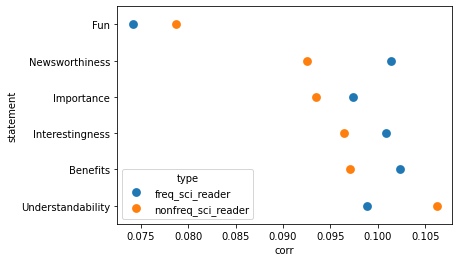

In [43]:
sns.pointplot(x='corr', y='statement', hue='type', data=t_df.sort_values('corr'), join=False)

<ipython-input-32-7ffe8ea5ebc9>:1: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='corr', y='statement', hue='type', data=t_df.sort_values('corr'), join=False)


<Axes: xlabel='corr', ylabel='statement'>

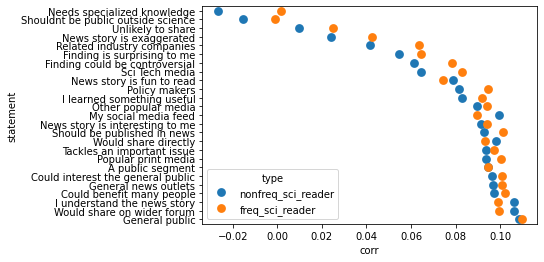

In [32]:
sns.pointplot(x='corr', y='statement', hue='type', data=t_df.sort_values('corr'), join=False)

In [49]:
def radar_plots_grid(dataframe, n_rows, n_cols, subplot_width=400, subplot_height=400, label_font_size=12):
    # Extract subject names and dimension values
    subjects = dataframe['topic']
    dimensions = list(dataframe.columns[1:])  # Assuming the dimensions start from the second column

    # Create subplots with NxM layout
    fig = make_subplots(rows=n_rows, cols=n_cols, subplot_titles=subjects, specs=[[{'type': 'polar'}]*n_cols]*n_rows)

    # Counter for the current subject
    subject_count = 0

    for i in range(1, n_rows + 1):
        for j in range(1, n_cols + 1):
            if subject_count < len(subjects):
                subject = subjects[subject_count]
                values = dataframe.loc[subject_count, dimensions].tolist()
                values += values[:1]  # Close the plot by adding the first value to the end

                trace = go.Scatterpolar(
                    r=values,
                    theta=dimensions + [dimensions[0]],  # Close the plot
                    fill='toself',
                    name=subject
                )

                fig.add_trace(trace, row=i, col=j)

                subject_count += 1

    # Customize radial axis ticks and labels
    tick_values = [0.2, 0.4, 0.6, 0.8, 1.0]  # Adjust these values as needed
    tick_labels = [f"{val:.1f}" for val in tick_values]  # Format tick labels

    for i in range(1, n_rows * n_cols + 1):
        fig.update_layout(
            polar=dict(radialaxis_tickvals=tick_values, radialaxis_ticktext=tick_labels, radialaxis_title_font_size=label_font_size)
        )

    # Update subplot layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[2, 4]  # Customize the range of the radial axis if needed
            ),
        ),
        showlegend=False,  # Remove the legend
        title_text='Radar Plots Grid',
        width=subplot_width,
        height=subplot_height
    )

    # Show the grid of radar plots
    fig.show()

def normalize_df(df):
    return (df-df.min())/(df.max()-df.min())

def radar_plot_grid(df, n, m, title=''):
    # Extract the dimension names and values
    dimensions = df.columns[1:]
    values = df[dimensions].values

    # Number of dimensions
    num_dimensions = len(dimensions)

    # Calculate the number of plots required
    num_plots = len(df)

    # Calculate the number of rows and columns in the grid
    rows = math.ceil(num_plots / m)
    cols = min(num_plots, m)

    # Create an array of evenly spaced angles for the radar chart
    angles = np.linspace(0, 2 * np.pi, num_dimensions, endpoint=False).tolist()
    angles += angles[:1]  # Repeat the first angle to close the plot

    # Create the grid of radar plots
    fig, axes = plt.subplots(rows, cols, figsize=(16, 10), subplot_kw={'polar': True})
    fig.subplots_adjust(hspace=0.5)

    # Loop through each subject and create a radar plot in the grid
    for i, ax in enumerate(axes.flat):
        if i < num_plots:
            subject = df.loc[i, 'topic']
            subject_values = df.loc[i, dimensions].tolist()

            # Create a radar plot for the current subject
            ax.fill(angles, subject_values + [subject_values[0]], 'b', alpha=0.1)

            ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
            # Set the labels for the angles
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(dimensions)

            # Add the title for the current subject
            ax.set_title(f'{subject}')

    # Remove empty subplots, if any
    for i in range(num_plots, rows * cols):
        fig.delaxes(axes.flat[i])

    # Add a common title for the entire grid
    plt.suptitle(title, fontsize=22)
    
    # Show the grid of radar plots
    plt.show()

In [107]:
df

,retrieved_on,selftext,media,link_flair_text,permalink,title,secure_media_embed,thumbnail,distinguished,domain,...,nonsci_General_news_outlets,topic,Importance,Newsworthiness,Understandability,Benefits,Interestingness,Fun,tgt,subject
0,1441288448,,None,None,/r/science/comments/29iq12/in_california_droug...,"In California Drought, Desperation May Make Wa...",{},http://a.thumbs.redditmedia.com/r2JhoKPyJBRINI...,None,blogs.kqed.org,...,1.722103,Humanities,2.072511,2.339433,2.545882,2.256766,2.112803,1.590302,41,Others
1,1441288402,,None,None,/r/science/comments/29itvt/top_male_science_pr...,"Top male science professors (Nobel Laureates, ...",{},http://a.thumbs.redditmedia.com/SfSTYKXDeFrLGr...,None,slate.com,...,2.421825,other,2.129089,2.106265,3.136231,2.280467,2.425995,1.623582,0,Others
2,1441288392,,None,Anthropology,/r/science/comments/29iuhu/study_suggests_mega...,Study suggests mega-population boom among sout...,{},default,None,news.wsu.edu,...,2.900486,other,1.649891,2.478488,3.708542,1.812304,2.709848,1.957107,0,Anthropology
3,1441288385,,None,Astronomy,/r/science/comments/29iuxg/controversial_theor...,Controversial theory suggests the speed of lig...,{},default,None,datnewz.com,...,2.176565,Humanities,1.124273,1.388919,1.830466,1.326704,1.359489,1.215767,16,Astronomy
4,1441288384,,None,None,/r/science/comments/29iv2l/russia_launching_po...,Russia launching powerful laser system,{},default,None,panicatech.com,...,1.776282,Humanities,1.194327,1.101225,1.191033,1.218764,0.682539,0.684532,0,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294869,1561252381,[deleted],None,None,/r/science/comments/bve8nu/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,4,Others
294870,1561252431,[deleted],None,None,/r/science/comments/bveca0/next_einstein_of_ou...,Next Einstein of our generation (?),{},default,None,nextshark.com,...,2.258176,Humanities,1.775899,1.965547,2.490825,1.745960,2.069073,1.769413,1,Others
294871,1561252453,,None,Geology,/r/science/comments/bvedvo/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,5,Geology
294872,1561252479,[deleted],None,Mathematics,/r/science/comments/bveftk/iranian_girl_scores...,Iranian girl scores higher than Einstein on Me...,{},default,None,nextshark.com,...,1.797426,Biology,1.204250,1.222198,1.775025,1.395468,1.270755,1.303661,2,Others


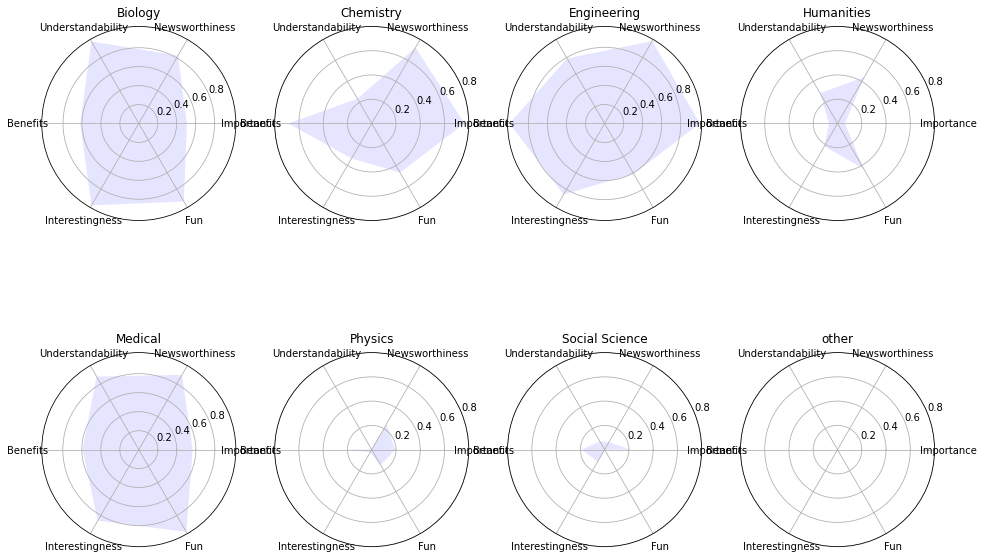

In [106]:
for s in sel_statements:
    s = s.replace(' ','_')
    df[sel_statements[s.replace('_', ' ')]] = df['sci_' + s] 
t_df = normalize_df(df[['topic'] + list(sel_statements.values())].groupby('topic').mean()).reset_index()
t_df = t_df.reset_index().drop(columns=['index'])
#radar_plots_grid(t_df, 4,4, 1000, 1000, 1)
radar_plot_grid(t_df, 4, 4)

In [80]:
subjects = set(df.link_flair_text.value_counts()[:20].index)
df['subject'] = [it if it in subjects else 'Others' for it in df.link_flair_text]

In [99]:
list(df.link_flair_text.value_counts()[:20].index)

['Health',
 'Biology',
 'Medicine',
 'Environment',
 'Astronomy',
 'Psychology',
 'Neuroscience',
 'Physics',
 'Animal Science',
 'Engineering',
 'Social Science',
 'Earth Science',
 'Cancer',
 'Chemistry',
 'Computer Science',
 'Anthropology',
 'Paleontology',
 'Geology',
 'Epidemiology',
 'Nanoscience']

Importance
Newsworthiness
Understandability
Benefits
Interestingness
Fun


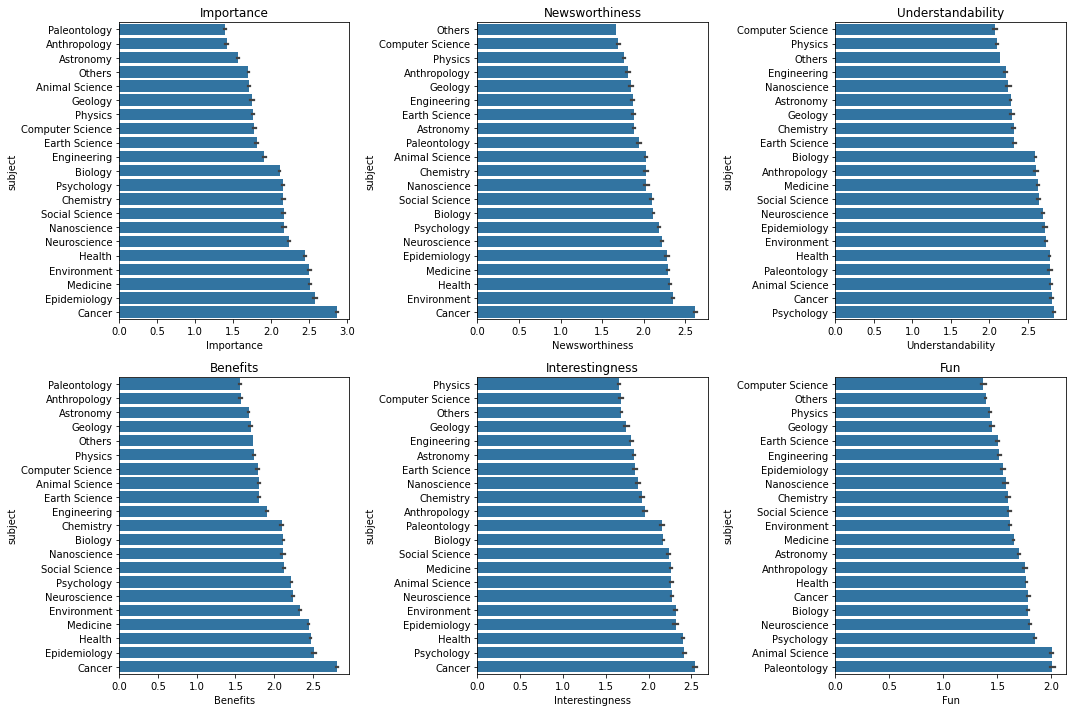

In [89]:
num_rows = 2
num_cols = 3

# Create a figure and axes for the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the keys and create bar plots
for idx, (_, key) in enumerate(sel_statements.items()):
    print(key)
    ax = axes[idx]  # Get the current subplot
    sns.barplot(y='subject', x=key, data=df, order=list(df[['subject', key]].groupby('subject').mean().sort_values(key).index), ax=ax)
    ax.set_title(key)  # Set the title for the subplot

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

<Axes: xlabel='count', ylabel='subject'>

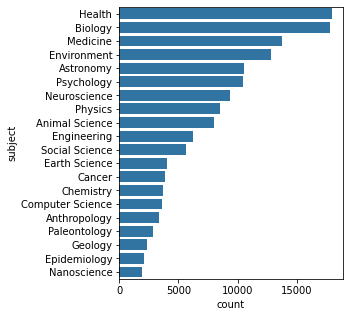

In [103]:
fig, axes = plt.subplots(figsize=(4, 5))
sns.countplot(y='subject',data=df, order=list(df.link_flair_text.value_counts()[:20].index))

In [117]:
df.groupby('link_flair_text').count().reset_index().sort_values('retrieved_on')

,link_flair_text,retrieved_on,selftext,media,permalink,title,secure_media_embed,thumbnail,distinguished,domain,...,nonsci_General_news_outlets,topic,Importance,Newsworthiness,Understandability,Benefits,Interestingness,Fun,tgt,subject
0,(PDF) Earth Science,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
604,Net Neutrality,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
605,Neurobiology AMA,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
606,Neurobiology Of Addictive Disorders AMA,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
607,Neuroengineering AMA,1,1,0,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Astronomy,10562,10562,566,10562,10562,10562,10562,3,10562,...,10562,10562,10562,10562,10562,10562,10562,10562,10562,10562
307,Environment,12828,12828,332,12828,12828,12828,12828,1,12828,...,12828,12828,12828,12828,12828,12828,12828,12828,12828,12828
530,Medicine,13781,13781,197,13781,13781,13781,13781,0,13781,...,13781,13781,13781,13781,13781,13781,13781,13781,13781,13781
87,Biology,17806,17806,415,17806,17806,17806,17806,2,17806,...,17806,17806,17806,17806,17806,17806,17806,17806,17806,17806


In [130]:
df.columns

Index(['retrieved_on', 'selftext', 'media', 'link_flair_text', 'permalink',
       'title', 'secure_media_embed', 'thumbnail', 'distinguished', 'domain',
       'created_utc', 'author_flair_text', 'media_embed', 'subreddit',
       'edited', 'score', 'stickied', 'secure_media', 'url', 'subreddit_id',
       'is_self', 'author', 'link_flair_css_class', 'gilded', 'id', 'archived',
       'author_flair_css_class', 'num_comments', 'over_18',
       'author_flair_richtext', 'sci_My_social_media_feed',
       'sci_General_public', 'sci_News_story_is_interesting_to_me',
       'sci_Tackles_an_important_issue',
       'sci_Shouldnt_be_public_outside_science',
       'sci_Would_share_on_wider_forum', 'sci_News_story_is_fun_to_read',
       'sci_Finding_is_surprising_to_me', 'sci_Sci_Tech_media',
       'sci_Other_popular_media', 'sci_Policy_makers',
       'sci_Should_be_published_in_news', 'sci_Could_benefit_many_people',
       'sci_Related_industry_companies', 'sci_Finding_could_be_controver

In [131]:
for idx, (_, key) in enumerate(sel_statements.items()):
    print(key, df[key].corr(df['num_comments']))

Importance 0.10371479380623935
Newsworthiness 0.10567486605629951
Understandability 0.10329470325469418
Benefits 0.10730984240418184
Interestingness 0.10607152613928442
Fun 0.07298547254283215


In [118]:
df['field_cnt'] = df.groupby('link_flair_text').transform('count').reset_index()['retrieved_on']

In [110]:
top_fields = list(df.link_flair_text.value_counts()[:20].index)


In [122]:
t_df = df[df['link_flair_text'].isin(top_fields)][['link_flair_text', 'field_cnt', 'Newsworthiness', 'score']].groupby('link_flair_text').mean().reset_index()

In [125]:
df.Newsworthiness.corr(df.field_cnt)

0.15035985527216397

In [126]:
df.Newsworthiness.corr(df.score)

0.10133419475608664

In [108]:
fig, axes = plt.subplots(figsize=(4, 4))
plt.text(0,80, 'Corr = 0.08', color='red')
sns.scatterplot(y='coverage_cnt', x='doi_newsworthiness', data=df.drop_duplicates('doi'),ax=axes)
plt.xlabel('Paper Newsworthiness')
plt.ylabel('Coverage Count')
#plt.savefig('../shared_data/figures/coverage_cnt_value_ranking_article_hist.pdf', bbox_inches='tight')

,retrieved_on,selftext,media,link_flair_text,permalink,title,secure_media_embed,thumbnail,distinguished,domain,...,nonsci_General_news_outlets,topic,Importance,Newsworthiness,Understandability,Benefits,Interestingness,Fun,tgt,subject
0,1441288448,,None,None,/r/science/comments/29iq12/in_california_droug...,"In California Drought, Desperation May Make Wa...",{},http://a.thumbs.redditmedia.com/r2JhoKPyJBRINI...,None,blogs.kqed.org,...,1.722103,Humanities,2.072511,2.339433,2.545882,2.256766,2.112803,1.590302,41,Others
1,1441288402,,None,None,/r/science/comments/29itvt/top_male_science_pr...,"Top male science professors (Nobel Laureates, ...",{},http://a.thumbs.redditmedia.com/SfSTYKXDeFrLGr...,None,slate.com,...,2.421825,other,2.129089,2.106265,3.136231,2.280467,2.425995,1.623582,0,Others
2,1441288392,,None,Anthropology,/r/science/comments/29iuhu/study_suggests_mega...,Study suggests mega-population boom among sout...,{},default,None,news.wsu.edu,...,2.900486,other,1.649891,2.478488,3.708542,1.812304,2.709848,1.957107,0,Anthropology
3,1441288385,,None,Astronomy,/r/science/comments/29iuxg/controversial_theor...,Controversial theory suggests the speed of lig...,{},default,None,datnewz.com,...,2.176565,Humanities,1.124273,1.388919,1.830466,1.326704,1.359489,1.215767,16,Astronomy
4,1441288384,,None,None,/r/science/comments/29iv2l/russia_launching_po...,Russia launching powerful laser system,{},default,None,panicatech.com,...,1.776282,Humanities,1.194327,1.101225,1.191033,1.218764,0.682539,0.684532,0,Others
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294869,1561252381,[deleted],None,None,/r/science/comments/bve8nu/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,4,Others
294870,1561252431,[deleted],None,None,/r/science/comments/bveca0/next_einstein_of_ou...,Next Einstein of our generation (?),{},default,None,nextshark.com,...,2.258176,Humanities,1.775899,1.965547,2.490825,1.745960,2.069073,1.769413,1,Others
294871,1561252453,,None,Geology,/r/science/comments/bvedvo/extraterrestrial_or...,Extraterrestrial organic matter preserved in 3...,{},default,None,sciencedirect.com,...,2.046151,Humanities,1.329057,1.237226,1.486772,1.315613,0.948815,0.917306,5,Geology
294872,1561252479,[deleted],None,Mathematics,/r/science/comments/bveftk/iranian_girl_scores...,Iranian girl scores higher than Einstein on Me...,{},default,None,nextshark.com,...,1.797426,Biology,1.204250,1.222198,1.775025,1.395468,1.270755,1.303661,2,Others


In [78]:
key = 'score'#, 'Tackles an important issue'
df['tgt'] = df[key]
mod = ols(formula = 'tgt' + ' ~ Fun + Interestingness + Understandability + Newsworthiness + Importance + Benefits',
                      data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                    tgt   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     603.1
Date:                Wed, 24 Jan 2024   Prob (F-statistic):               0.00
Time:                        13:42:39   Log-Likelihood:            -2.7483e+06
No. Observations:              294874   AIC:                         5.497e+06
Df Residuals:                  294867   BIC:                         5.497e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -605.3424     29.53

In [48]:
data_df[:30000].to_csv('../data/reddit_science_30k.csv',index=False)

In [101]:
data_df = pd.read_csv('../data/reddit_science_30k_with_topic.csv')

In [21]:
#data_df['category_cnt'] = [len(eval(it)) for it in data_df['pred_labels']]
#data_df = data_df[data_df['category_cnt']==1]
#data_df['category_cnt'].value_counts()

In [103]:
data_df['topic'] = ['other' if len(eval(it)) == 0 else eval(it)[0] for it in data_df['pred_labels']]
data_df['topic'].value_counts()

other             10284
Physics            5666
Engineering        4989
Biology            3312
Medical            1879
Chemistry          1808
Social Science     1198
Humanities          864
Name: topic, dtype: int64

In [100]:
data_df['link_flair_text']

0                 NaN
3           Astronomy
4                 NaN
7            Medicine
8                 NaN
             ...     
29993             NaN
29994             NaN
29995             NaN
29997             NaN
29998    Neuroscience
Name: link_flair_text, Length: 17744, dtype: object

In [115]:
subjects = set(data_df.link_flair_text.value_counts()[:20].index)

<AxesSubplot:xlabel='score', ylabel='link_flair_text'>

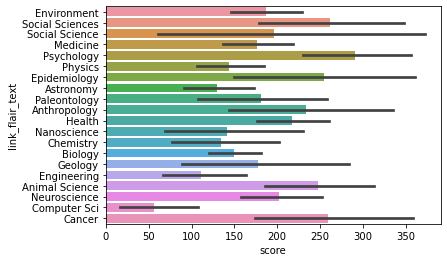

In [113]:
sns.barplot(y='link_flair_text',x='score',data=data_df, order = list(set(data_df.link_flair_text.value_counts()[:20].index)))

<AxesSubplot:xlabel='count', ylabel='link_flair_text'>

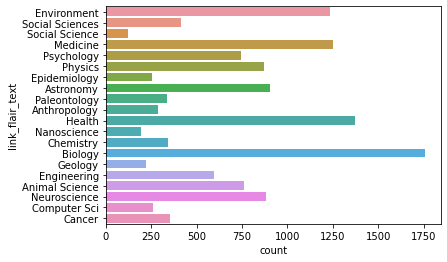

In [114]:
sns.countplot(y='link_flair_text',data=data_df, order = list(set(data_df.link_flair_text.value_counts()[:20].index)))

In [121]:
t_df = data_df[data_df.link_flair_text.isin(subjects)]
t_df['split'] = split_labels(len(t_df))
t_df.to_csv('../data/reddit_science_train.csv',index=False)

<ipython-input-121-b28564724568>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_df['split'] = split_labels(len(t_df))


<AxesSubplot:xlabel='score', ylabel='topic'>

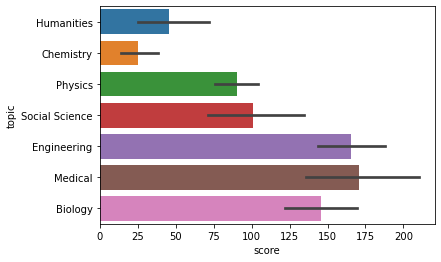

In [97]:
sns.barplot(y='topic',x='score',data=data_df, order=['Humanities', 'Chemistry', 'Physics', 'Social Science', 'Engineering', 'Medical', 'Biology'])

<AxesSubplot:xlabel='count', ylabel='topic'>

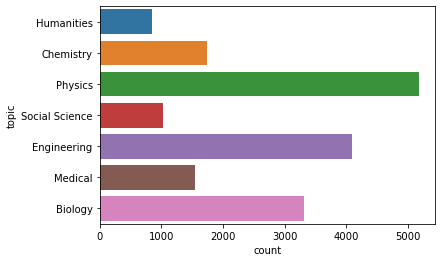

In [98]:
sns.countplot(y='topic',data=data_df, order=['Humanities', 'Chemistry', 'Physics', 'Social Science', 'Engineering', 'Medical', 'Biology'])